# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [4]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [1]:

from src.data import get_data_loaders
from src.train import optimize
from src.helpers import load_model, replace_insatance
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch
from src.transfer import get_model_transfer_learning

print_model=0
batch_size = 32  # size of the minibatch for stochastic gradient descent (or Adam)
num_epochs = 70     # number of epochs for training
num_classes = 7       # number of classes. Do not change this
learning_rate =0.05*(0.6)**0  # Learning rate for SGD (or Adam)
weight_decay = 0.001     # regularization. Increase this to combat overfitting
momentum=0.9 
accumulation_steps=2
model_name= "shufflenet_v2_x1_0"

suffix=''

data_loaders = get_data_loaders(batch_size=batch_size, is_mel=False)
# torch.backends.cuda.matmul.allow_tf32=True
# torch.backends.cudnn.allow_tf32=True

model = get_model_transfer_learning(model_name,n_classes=num_classes)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cel
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay,)


#milestones=[5,9,12, *range(12,num_epochs,2)]
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2,threshold=1e-3,verbose=True)
#scheduler = lr_scheduler.ExponentialLR(optimizer,gamma=0.7)

def step(loss ,epoch=None):
    scheduler.step(loss)

def loss(output,target):
    #target=F.one_hot(target, num_classes).float()

    return F.cross_entropy(output, target,label_smoothing=0.03)




s_epoch=load_model(model_name+suffix,model)
if print_model:
    print(f"model {model_name} has :{sum(p.numel() for p in model.parameters())/1e6} M parameters ")
    print(f"Effictive W>0.01 precentage: ")
    print('\n'.join('layer {} has : {}'.format(n,torch.sum(torch.abs(p)>0.01)/p.numel()) for n, p in model.named_parameters()))
#replace_insatance(model,torch.nn.LeakyReLU, models.Swish())
#print(model)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    s_epoch=s_epoch,
    n_epochs=num_epochs,
    model_name=model_name+suffix,
    step=step,
    accumulation_steps=accumulation_steps,
    run_logs=True,
    
)

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])
New wheigts are initilaized!!


Training:   0%|                                         | 0/813 [00:00<?, ?it/s]
/opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [31,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
layers=dict( model_transfer.named_modules())
layers

{'': RegNet(
   (stem): SimpleStemIN(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (trunk_output): Sequential(
     (block1): AnyStage(
       (block1-0): ResBottleneckBlock(
         (proj): Conv2dNormActivation(
           (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
           (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
         (f): BottleneckTransform(
           (a): Conv2dNormActivation(
             (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
             (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): ReLU(inplace=True)
           )
           (b): Conv2dNormActivation(
             (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4,

In [ ]:

for param in layers['trunk_output.block3'].parameters():
    param.requires_grad = True


In [ ]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 60  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.0001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

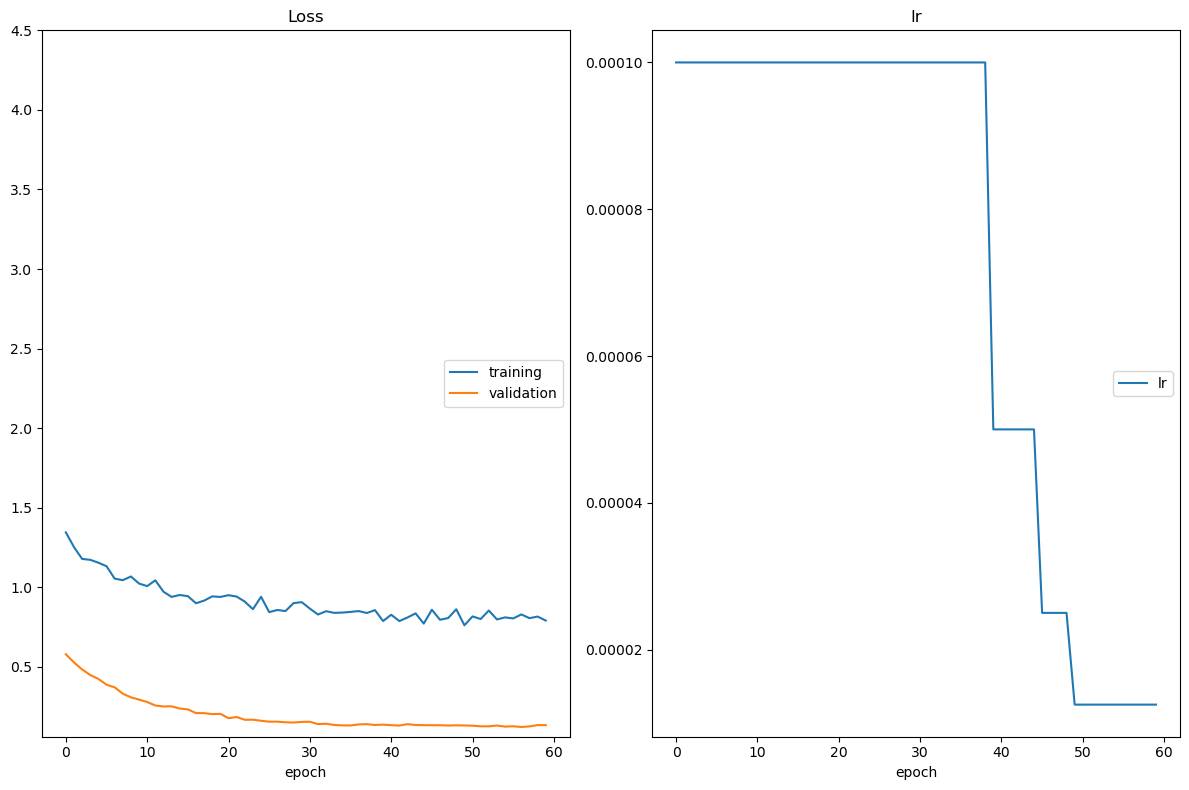

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
    patience=3
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [ ]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("regnet_y_800mf", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:03<00:00,  5.62it/s]

Test Loss: 0.623576


Test Accuracy: 84% (1060/1250)


0.6235756531357765

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [ ]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


  0%|                                          | 1/1250 [00:00<03:25,  6.06it/s]/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %372 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664405705473/work/torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████| 1250/1250 [00:22<00:00, 54.75it/s]


Accuracy: 0.828


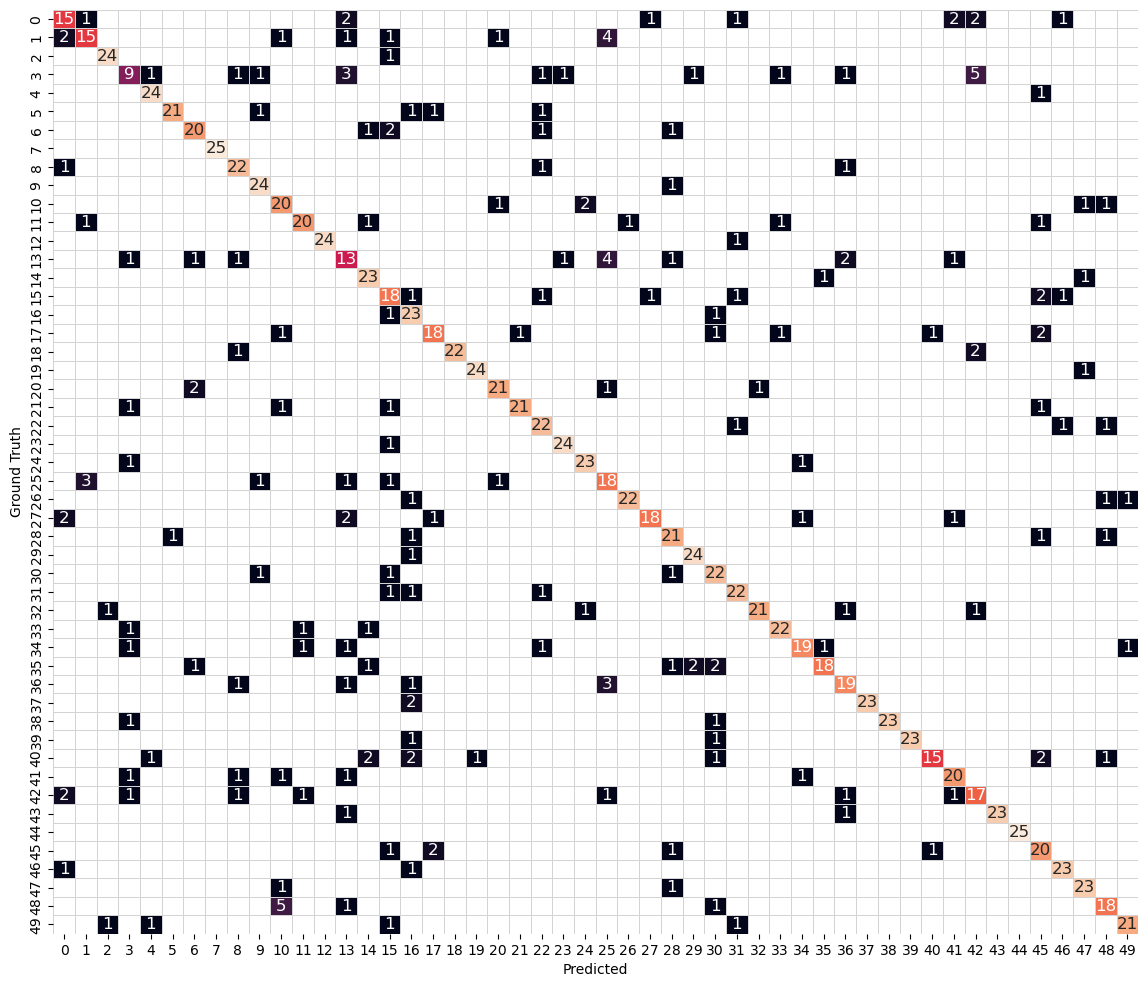

In [ ]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)

# shuffle

In [ ]:
batch_size = 128  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

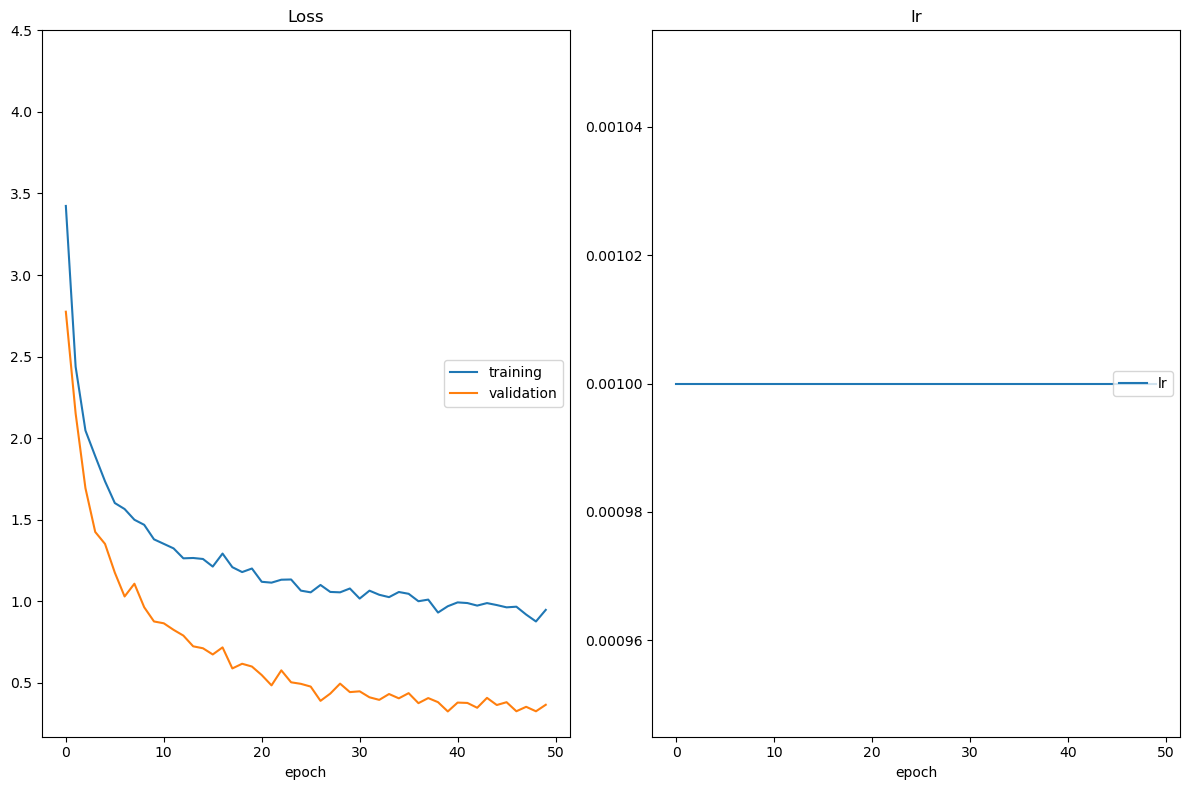

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("shufflenet_v2_x1_5")

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
)

In [ ]:
from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 10/10 [00:02<00:00,  3.78it/s]

Test Loss: 0.852020


Test Accuracy: 78% (975/1250)


0.8520200371742248

In [ ]:
model_transfer

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
for param in model_transfer.parameters():
    param.requires_grad = True

for param in model_transfer.conv1.parameters():
    param.requires_grad = False


In [ ]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.001 # regularization. Increase this to combat overfitting

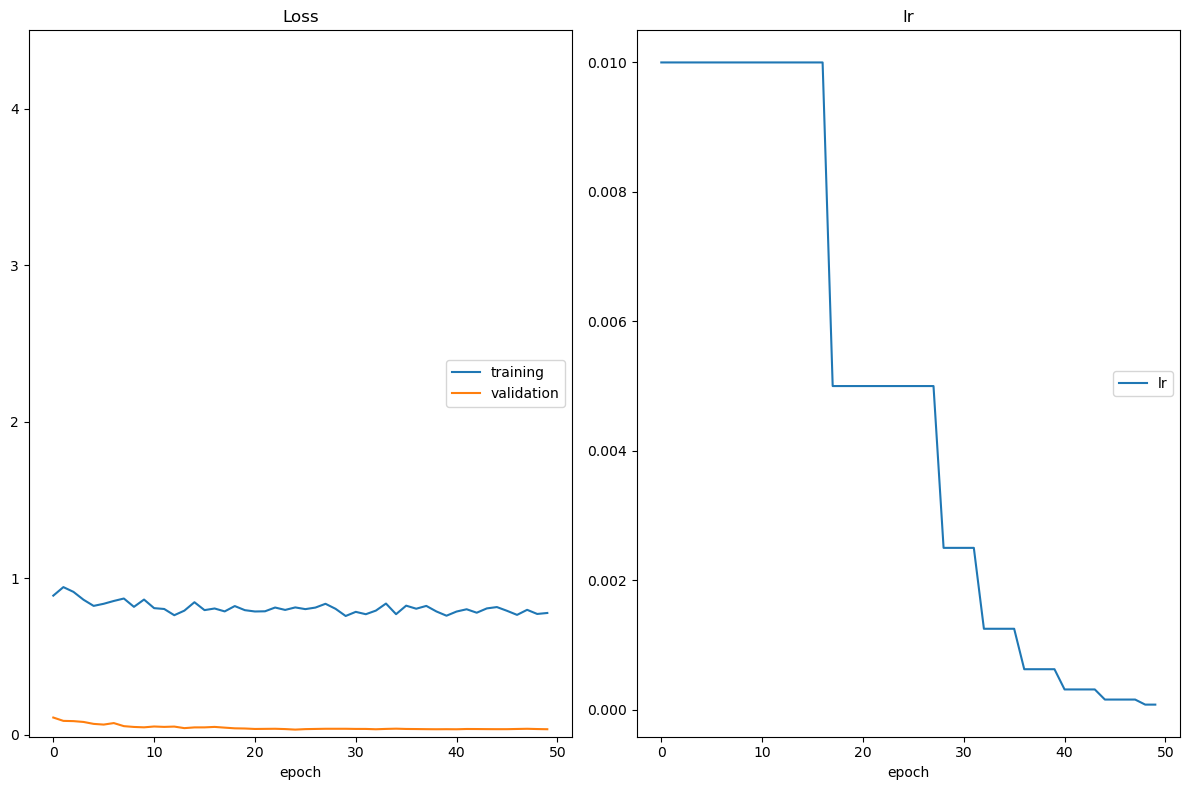

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning
import torch
# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("shufflenet_v2_x1_5")
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt")
)
for param in model_transfer.parameters():
    param.requires_grad = True

for param in model_transfer.conv1.parameters():
    param.requires_grad = False
# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
)

In [ ]:
from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:02<00:00,  8.88it/s]

Test Loss: 0.636295


Test Accuracy: 85% (1071/1250)


0.6362950045615434

In [ ]:
batch_size = 128  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 100  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.001 # regularization. Increase this to combat overfitting

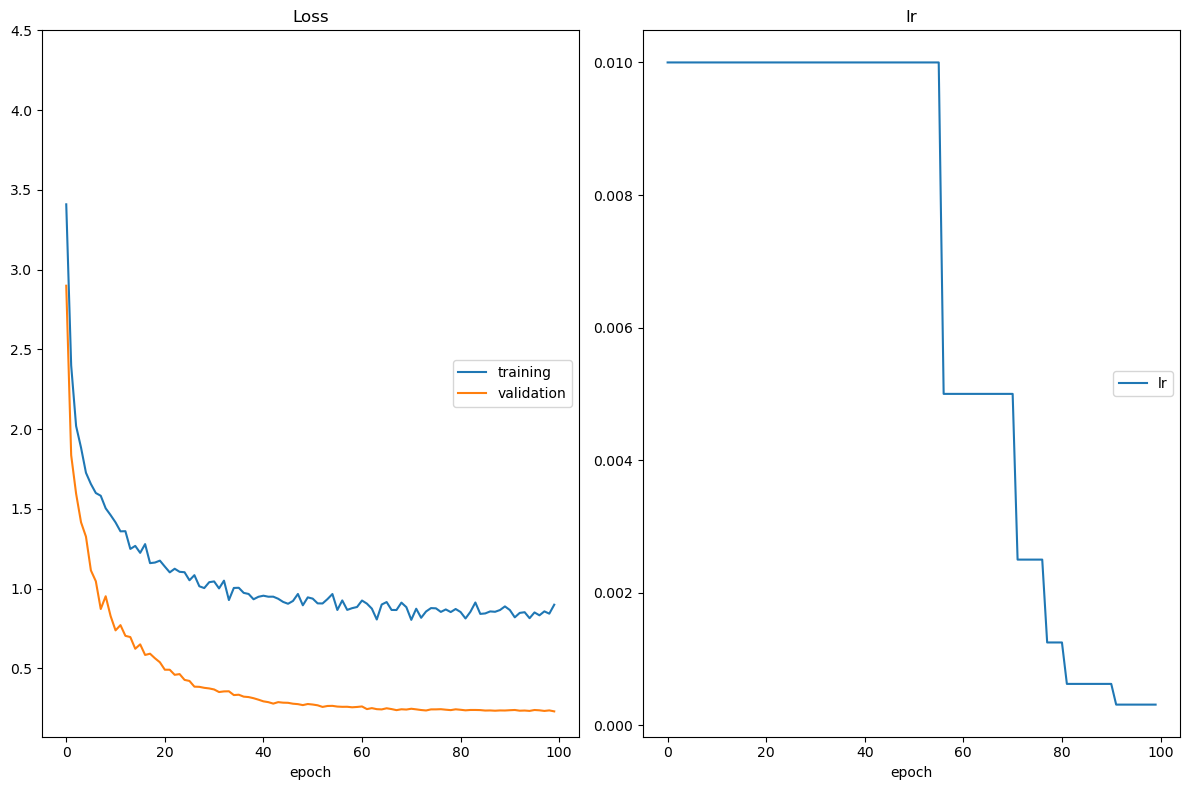

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning
import torch
from src.model import SepConv
# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("shufflenet_v2_x1_5")
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt")
)
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.stage4=SepConv(352,704,3,stride=2,padding=1,growth_factor=3,depth_count=3)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/stage4_transfer.pt",
    interactive_tracking=True,
    patience=3
)

In [ ]:
from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 10/10 [00:02<00:00,  3.93it/s]

Test Loss: 0.816840


Test Accuracy: 79% (989/1250)


0.8168396055698395

# Mobilenet

In [ ]:
batch_size = 128  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

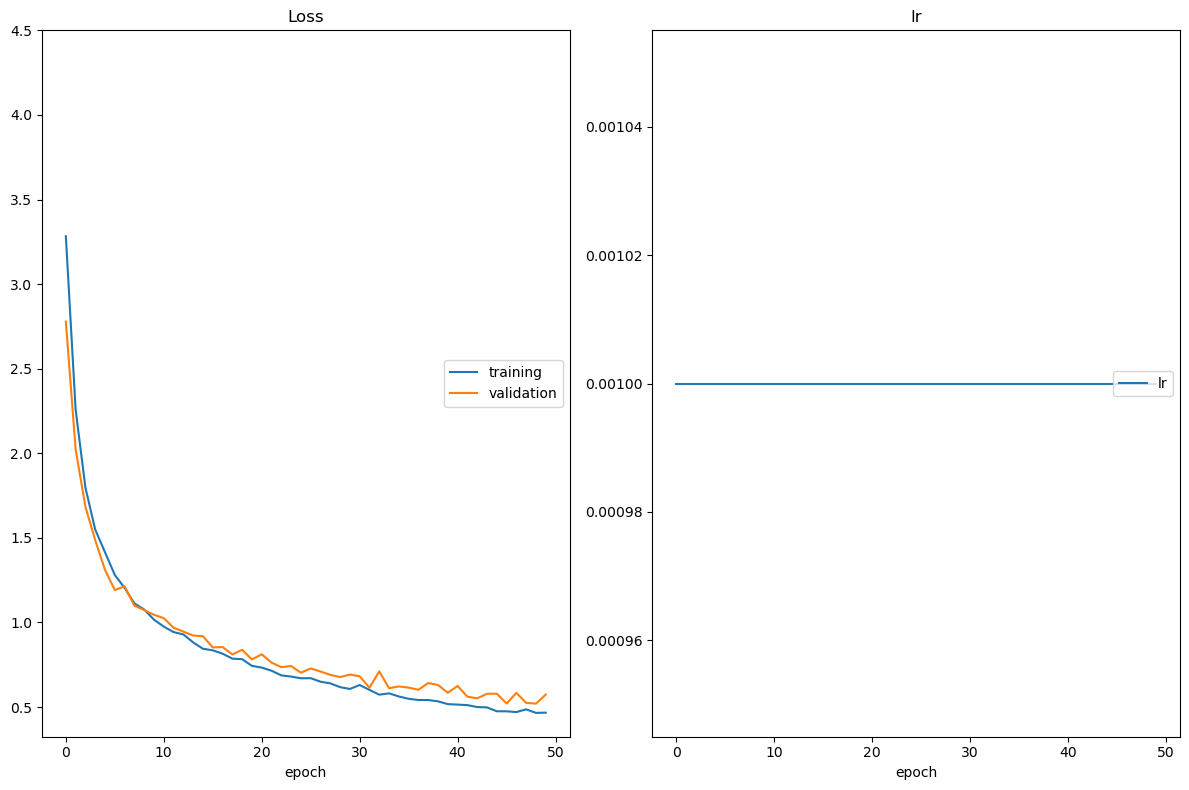

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("mobilenet_v3_large")

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/mobile_transfer.pt",
    interactive_tracking=True,
)

In [ ]:
from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 10/10 [00:03<00:00,  3.21it/s]

Test Loss: 0.861766


Test Accuracy: 77% (974/1250)


0.8617662429809569

In [ ]:
model_transfer

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
batch_size = 128  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 100  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.001 # regularization. Increase this to combat overfitting

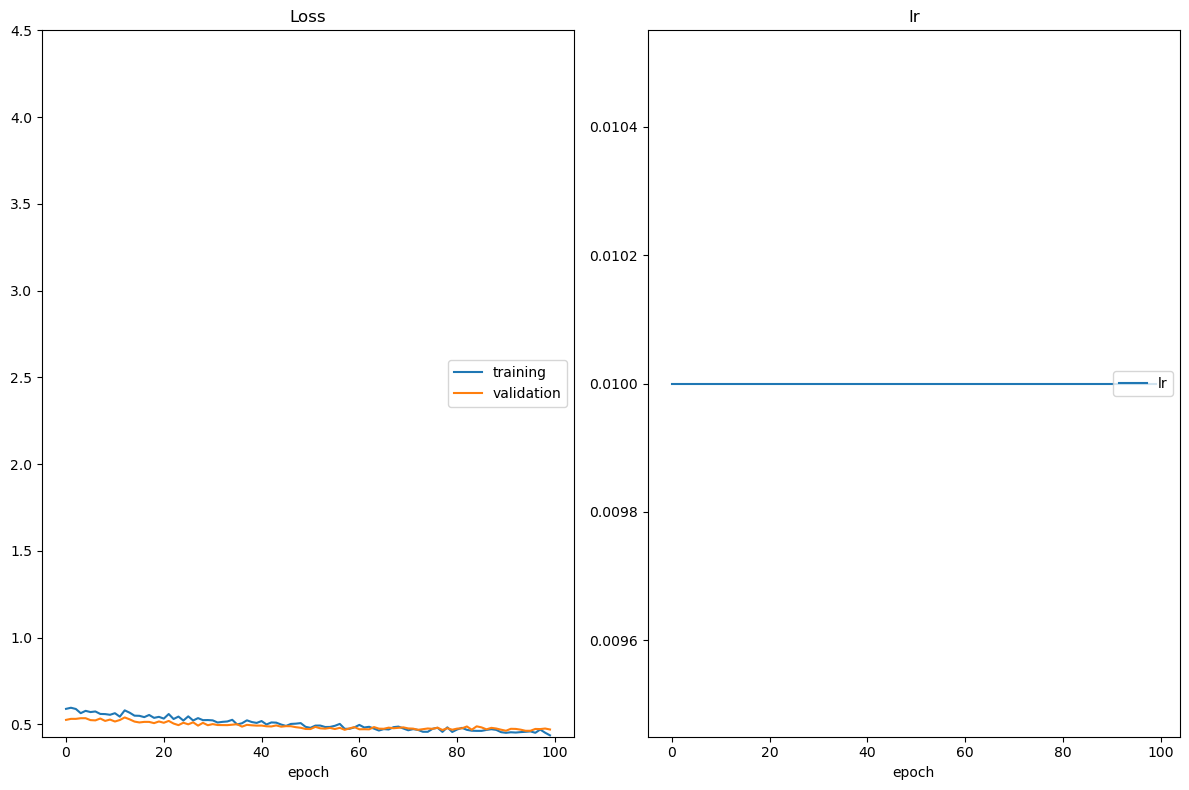

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning
import torch
# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("mobilenet_v3_large")
model_transfer.load_state_dict(
    torch.load("checkpoints/mobile_transfer.pt")
)
for param in model_transfer.parameters():
    param.requires_grad = True

for param in model_transfer.features.parameters():
    param.requires_grad = False
# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
)

In [ ]:
from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]

Test Loss: 0.814779


Test Accuracy: 79% (996/1250)


0.8147790968418123